In [77]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix
%matplotlib inline

In [2]:
# Dataset
df = pd.read_csv('Obesity_data.csv')

In [3]:
# Head
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
# Shape
df.shape

(2111, 17)

In [5]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [9]:
# Select useful columns
df = df[['Gender','Age','Height','Weight','SMOKE','NObeyesdad']]

In [12]:
# Calculate BMI
df['BMI'] = df['Weight'] / df['Height']

/tmp/ipykernel_273/589206156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BMI'] = df['Weight'] / df['Height']


In [28]:
# Rename target column
df = df.rename(columns={"NObeyesdad":"Category(BMI)"})

In [35]:
# Classify BMI category 
def classify_bmi(bmi):
    if bmi < 16:
        return 'Underweight'
    elif 16 <= bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25.0:
        return 'Normal'
    elif 25.0 <= bmi < 35.0:
        return 'Overweight'
    elif 35.0 <= bmi < 45.0:
        return 'Obesity'
    else:
        return 'Extreme Obesity'

df['Category(BMI)'] = df['BMI'].apply(classify_bmi)

In [78]:
# Copy cleaned data to preprocessed data
preprocessed_df = df.copy()

In [82]:
label_encoder = LabelEncoder()
preprocessed_df['Gender'] = label_encoder.fit_transform(df['Gender'])

In [84]:
preprocessed_df['SMOKE'] = label_encoder.fit_transform(df['SMOKE'])
preprocessed_df['Category(BMI)'] = label_encoder.fit_transform(df['Category(BMI)'])

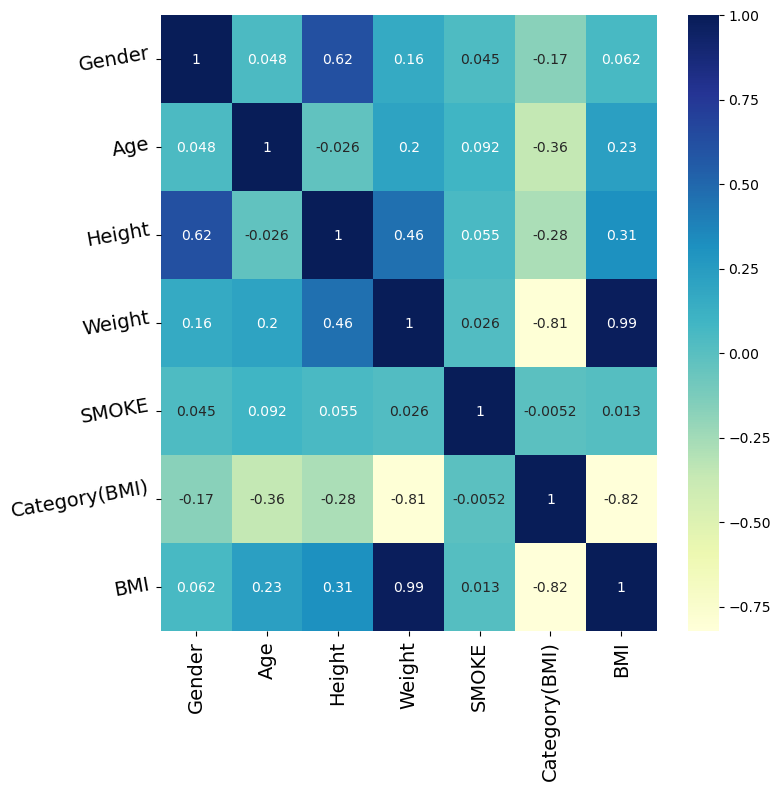

In [85]:
# Correlation
df_corr = preprocessed_df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(df_corr,
           annot=True,
           cmap='YlGnBu')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14,rotation=10)
plt.show();

In [86]:
# Change input features dtype to same scale
standard_scaler = StandardScaler()
standard_data = standard_scaler.fit_transform(preprocessed_df)

In [87]:
standard_df = pd.DataFrame(standard_data,columns = preprocessed_df.columns)

In [91]:
# Independent features and categorical features
X = preprocessed_df[['Gender','Age','Height','Weight','SMOKE','BMI']]
y = preprocessed_df['Category(BMI)']

In [119]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted,average='weighted') # Calculate F1-score
    precision = precision_score(true, predicted,average='weighted') # Calculate Precision
    recall = recall_score(true, predicted,average='weighted')  # Calculate Recall
    return acc, f1, precision, recall

In [120]:
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train)  # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1, model_train_precision, model_train_recall = evaluate_clf(y_train, y_train_pred)

        # Test set performance
        model_test_accuracy, model_test_f1, model_test_precision, model_test_recall = evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1))
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        accuracy_list.append(model_test_accuracy)
        print('='*35)
        print('\n')
        
    report = pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=["Accuracy"])
        
    return report


In [106]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "SVM":SVC()
}

In [121]:
result = evaluate_models(X,y,models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000


Gradient Boosting
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000


Logistic Regression
Model performance for Training set
- Accuracy: 0.9384
- F1 score: 0.9367
- Precision: 0.9362
- Recall: 0.9384
----------------------------------
Model performance for Test set

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

In [76]:
X

,Gender,Age,Height,Weight,SMOKE,BMI
0,-1.011914,-0.522124,-0.875589,-0.862558,-0.145900,-0.780550
1,-1.011914,-0.522124,-1.947599,-1.168077,6.853997,-0.967342
2,0.988227,-0.206889,1.054029,-0.366090,-0.145900,-0.551160
3,0.988227,0.423582,1.054029,0.015808,-0.145900,-0.161631
4,0.988227,-0.364507,0.839627,0.122740,-0.145900,-0.013260
...,...,...,...,...,...,...
2106,-1.011914,-0.525774,0.097045,1.711763,-0.145900,1.835321
2107,-1.011914,-0.367195,0.502844,1.800914,-0.145900,1.812332
2108,-1.011914,-0.281909,0.541672,1.798868,-0.145900,1.799102
2109,-1.011914,0.007776,0.404927,1.785780,-0.145900,1.824518
